### by:
##### Karthik Bhat Beedubail
##### Date: 4 April 2024

### Analysis of crime data in Toronto
For this assignment, you will access crime data in Toronto, available on the Toronto Public Service Public
Safety Data Portal: https://data.torontopolice.on.ca
You will explore patterns of point pattern analysis, density of crimes, and compute global Moran’s I
(using an appropriate neighbor). In the final question, you will explore other datasets, such as age,
employment, income of the neighborhood, etc. to see if any of these might contribute to or explain the
patterns of crime.
From the Toronto Public Service Public Safety Data Portal, access at least 6 months of data of
the crime dataset of your choosing; you can explore any of the categories and select the major crime
indicator (MCI) of your choosing, for an area of interest. It may be the entire city of Toronto, or a
particular neighborhood(s) you are interested in analyzing.
You can query and download a file from the Toronto Public Service Public Safety Data Portal and
load that into your assignment, however, full marks will be considered only if the API is accessed directly
in your Notebook.

### Answer:


Here I am considering Toronto Homicide Open data: https://data.torontopolice.on.ca/datasets/TorontoPS::homicides-open-data-asr-rc-tbl-002/about
As of 2 April 2024, we have 1,396 records.
* Neighbourhoods GeoJson source: https://open.toronto.ca/dataset/neighbourhoods/

In [83]:
import requests
import geopandas as gpd 
def fetch_feature_service_data(url, query_params):
    response = requests.get(url, params=query_params)
    if response.status_code == 200:
        data = response.json()
        return data
    else:
        print("Error fetching data:", response.text)
        return None

Lets try to grab 1 deacde worth of data 1 January 2013 to present. (Note: As of 2 April 2024, data is updated till December 2023)

In [84]:
# Define the URL of the feature service
url = "https://services.arcgis.com/S9th0jAJ7bqgIRjw/arcgis/rest/services/Homicides_Open_Data_ASR_RC_TBL_002/FeatureServer/0/query"

# Define query parameters
query_params = {
    "where": "(OCC_DATE>=TIMESTAMP '2013-01-01 00:00:00')",
    "outFields": "*",
    "outSR": "4326",
    "f": "geojson"
}

In [85]:
# Fetch data from the feature service
homicides_feature_service_data = fetch_feature_service_data(url, query_params)

In [86]:
# Create GeoDataFrame from GeoJSON data
homicides_gdf = gpd.GeoDataFrame.from_features(homicides_feature_service_data['features'])
if homicides_gdf.crs is None:
    homicides_gdf.set_crs(epsg=4326, inplace=True)
homicides_gdf    

,geometry,OBJECTID,EVENT_UNIQUE_ID,OCC_DATE,OCC_YEAR,OCC_MONTH,OCC_DAY,OCC_DOW,OCC_DOY,DIVISION,HOMICIDE_TYPE,HOOD_158,NEIGHBOURHOOD_158,HOOD_140,NEIGHBOURHOOD_140,LONG_WGS84,LAT_WGS84
0,POINT (-79.49471 43.77769),606,GO-20134821260,1357016400000,2013,January,1,Tuesday,1,D31,Stabbing,27,York University Heights,27,York University Heights (27),-79.494706,43.777690
1,POINT (-79.35908 43.66034),607,GO-20134842775,1358485200000,2013,January,18,Friday,18,D51,Shooting,72,Regent Park,72,Regent Park (72),-79.359077,43.660345
2,POINT (-79.56843 43.67571),608,GO-20134724330,1358571600000,2013,January,19,Saturday,19,D23,Other,7,Willowridge-Martingrove-Richview,7,Willowridge-Martingrove-Richview (7),-79.568426,43.675709
3,POINT (-79.42379 43.67028),609,GO-20134911563,1358571600000,2013,January,19,Saturday,19,D14,Other,172,Dovercourt Village,93,Dovercourt-Wallace Emerson-Junction (93),-79.423789,43.670277
4,POINT (-79.35634 43.78629),610,GO-20134902220,1359781200000,2013,February,2,Saturday,33,D33,Other,47,Don Valley Village,47,Don Valley Village (47),-79.356338,43.786285
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
804,POINT (-79.36424 43.65910),1410,GO-2024545700,1710216000000,2024,March,12,Tuesday,72,D51,Shooting,72,Regent Park,72,Regent Park (72),-79.364238,43.659103
805,POINT (-79.36424 43.65910),1411,GO-2024545700,1710216000000,2024,March,12,Tuesday,72,D51,Shooting,72,Regent Park,72,Regent Park (72),-79.364238,43.659103
806,POINT (-79.20899 43.74516),1412,GO-2024558575,1710388800000,2024,March,14,Thursday,74,D43,Other,139,Scarborough Village,139,Scarborough Village (139),-79.208993,43.745156
807,POINT (-79.46692 43.76885),1413,GO-2024671809,1711598400000,2024,March,28,Thursday,88,D32,Shooting,27,York University Heights,27,York University Heights (27),-79.466916,43.768847


In [87]:
homicides_gdf["HOMICIDE_TYPE"].unique()

array(['Stabbing', 'Shooting', 'Other'], dtype=object)

We get to see that there are 791 Homicide cases recorded from <b>1 January 2013 to 31 december 2023</b> This is the up to data tha we have for now. this is a deccade worth data and lets do our analysis around it.

Lets also grab toronto city Neighbourhoods data.
Please keep Neighbourhoods GeoJson in `Data` folder and use it to load (source: https://open.toronto.ca/dataset/neighbourhoods/)

In [88]:
import matplotlib.pyplot as plt
gdf_neigh = gpd.read_file("Data/Neighbourhoods.geojson")
gdf_neigh

,_id,AREA_ID,AREA_ATTR_ID,PARENT_AREA_ID,AREA_SHORT_CODE,AREA_LONG_CODE,AREA_NAME,AREA_DESC,CLASSIFICATION,CLASSIFICATION_CODE,OBJECTID,geometry
0,1,2502366,26022881,0,174,174,South Eglinton-Davisville,South Eglinton-Davisville (174),Not an NIA or Emerging Neighbourhood,NA,17824737.0,"MULTIPOLYGON (((-79.38635 43.69783, -79.38623 ..."
1,2,2502365,26022880,0,173,173,North Toronto,North Toronto (173),Not an NIA or Emerging Neighbourhood,NA,17824753.0,"MULTIPOLYGON (((-79.39744 43.70693, -79.39837 ..."
2,3,2502364,26022879,0,172,172,Dovercourt Village,Dovercourt Village (172),Not an NIA or Emerging Neighbourhood,NA,17824769.0,"MULTIPOLYGON (((-79.43411 43.66015, -79.43537 ..."
3,4,2502363,26022878,0,171,171,Junction-Wallace Emerson,Junction-Wallace Emerson (171),Not an NIA or Emerging Neighbourhood,NA,17824785.0,"MULTIPOLYGON (((-79.43870 43.66766, -79.43841 ..."
4,5,2502362,26022877,0,170,170,Yonge-Bay Corridor,Yonge-Bay Corridor (170),Not an NIA or Emerging Neighbourhood,NA,17824801.0,"MULTIPOLYGON (((-79.38404 43.64497, -79.38502 ..."
...,...,...,...,...,...,...,...,...,...,...,...,...
153,154,2502213,26022728,0,001,001,West Humber-Clairville,West Humber-Clairville (1),Not an NIA or Emerging Neighbourhood,NA,17827185.0,"MULTIPOLYGON (((-79.59037 43.73401, -79.58942 ..."
154,155,2502212,26022727,0,024,024,Black Creek,Black Creek (24),Neighbourhood Improvement Area,NIA,17827201.0,"MULTIPOLYGON (((-79.51915 43.77399, -79.51901 ..."
155,156,2502211,26022726,0,023,023,Pelmo Park-Humberlea,Pelmo Park-Humberlea (23),Not an NIA or Emerging Neighbourhood,NA,17827217.0,"MULTIPOLYGON (((-79.53225 43.73505, -79.52938 ..."
156,157,2502210,26022725,0,022,022,Humbermede,Humbermede (22),Neighbourhood Improvement Area,NIA,17827233.0,"MULTIPOLYGON (((-79.52813 43.74425, -79.52721 ..."


# PART A

## 1. Are the crimes clustered? Is there Central Tendency? Create a density map showing the local density (quadrat or kernel method may be used) and describe the results (< 100 words)

First lets plot there homicides crimes and analyse if they are clustered visually.

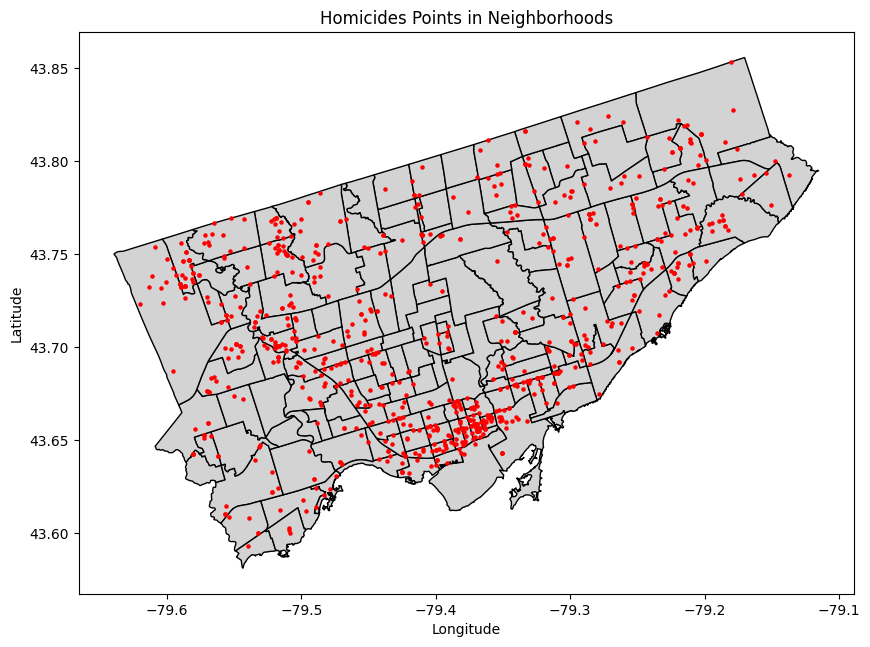

In [8]:
# Plot neighborhood map
ax = gdf_neigh.plot(figsize=(10, 10), color='lightgrey', edgecolor='black')

# Plot robbery points on the same axes
homicides_gdf.plot(ax=ax, color='red', markersize=5)

# Set axis labels and title
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Homicides Points in Neighborhoods')

# Show plot
plt.show()

 <b>We can Observe that mostly crimes are clustered in southern and south-west regions.</b>

Now lets perform bit of central tendancy analysis using PySAL. For simplicity lets consider following 3 methods and plot the points.
1. Mean
2. manhattan median
3. Euclidean mean
<br> Reference: https://pysal.org/notebooks/explore/pointpats/centrography.html#Central-Tendency

In [9]:
#import centragraphy analysis functions 
from pointpats.centrography import hull, mbr, mean_center, weighted_mean_center, manhattan_median, std_distance,euclidean_median,ellipse
import numpy as np

In [10]:
# Extracting point coordinates from the GeoDataFrame
homicide_points = homicides_gdf[['LONG_WGS84', 'LAT_WGS84']].values

In [11]:
mean_center = mean_center(homicide_points)

In [12]:
manhattan_median = manhattan_median(homicide_points)

In [13]:
euclidean_median = euclidean_median(homicide_points)

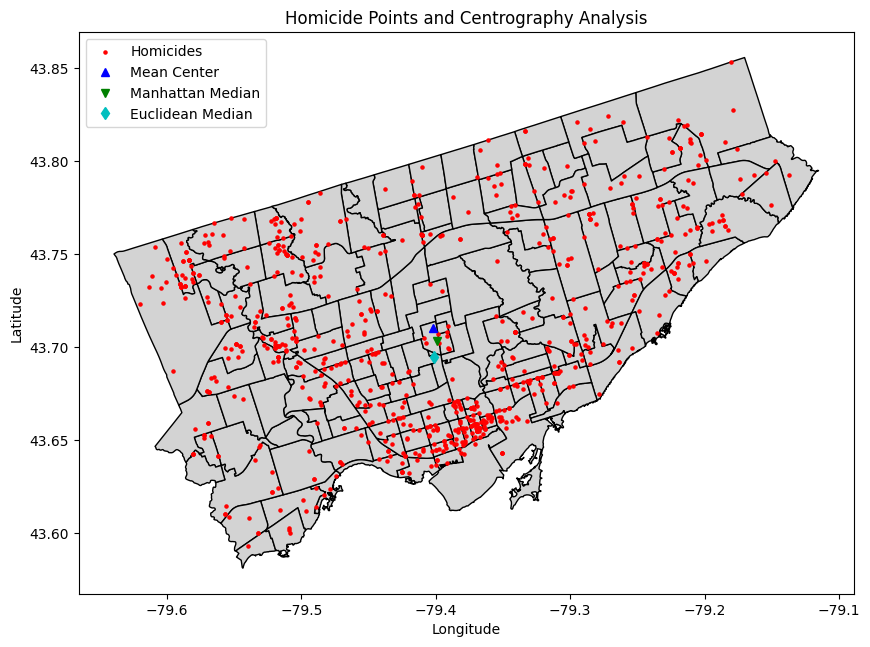

In [14]:
# Plot neighborhood map
ax = gdf_neigh.plot(figsize=(10, 10), color='lightgrey', edgecolor='black')

# Plot homicide points
homicides_gdf.plot(ax=ax, color='red', markersize=5, label='Homicides')

# Plot centrography results
plt.plot(mean_center[0], mean_center[1], 'b^', label='Mean Center')
plt.plot(manhattan_median[0], manhattan_median[1], 'gv', label='Manhattan Median')
plt.plot(euclidean_median[0], euclidean_median[1], 'cd', label='Euclidean Median')

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Homicide Points and Centrography Analysis')
plt.legend(numpoints=1)


<b>By this we can observe that all the central tendecy are close to one another with slight difference. It would be better to do this Point pattern analysis by considering a local density method like Quadrat.</b>

### Quadtrat analysis
Reference: https://pysal.org/notebooks/explore/pointpats/Quadrat_statistics.html#Quadrat-Statistic


Chi-squared test statistic: 475.3522867737948
Degrees of freedom: 8
Analytical p-value: 1.3610095302194895e-97


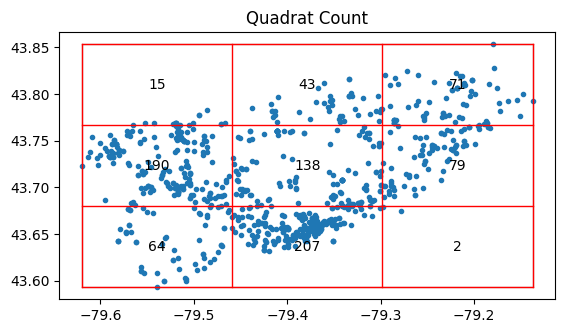

In [17]:
import pointpats.quadrat_statistics as qs
from pointpats import PointPattern

# Create PointPattern from homicide data
pp_homicide = PointPattern(homicide_points)

# Perform rectangle quadrat analysis
q_r = qs.QStatistic(pp_homicide, shape="rectangle", nx=3, ny=3)
q_r.plot()  # Plot the quadrats and point counts

print(f"Chi-squared test statistic: {q_r.chi2}")
print(f"Degrees of freedom: {q_r.df}")
print(f"Analytical p-value: {q_r.chi2_pvalue}")


Chi-squared test statistic (χ²): The value of 454.174 indicates a significant deviation from what would be expected if the homicides were distributed randomly across the quadrats. <br> Degrees of freedom (df): With 8 degrees of freedom, it provides the context for interpreting the χ² statistic against critical values or for calculating the p-value.

The extremely low p-value (4.71e-93) effectively rejects the null hypothesis of Complete Spatial Randomness at any conventional level (e.g., 0.05, 0.01). This means it's highly unlikely that the observed spatial pattern of homicides could be the result of a random process.

We know that Qudrats can be in different shapes, so lets double check with another shape like hexagon and see if our conclusion is correct.

Chi-squared test statistic: 1705.6168108776267
Degrees of freedom: 23
Analytical p-value: 0.0


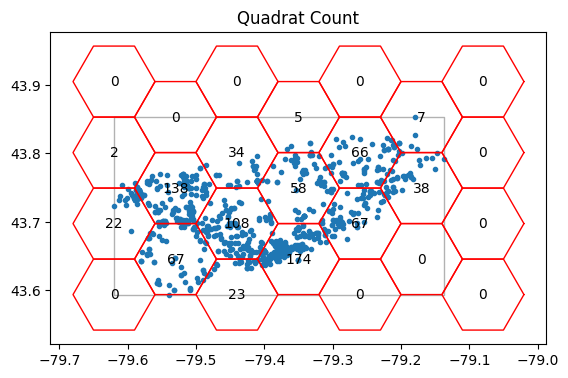

In [18]:
# Perform hexagon quadrat analysis
q_h = qs.QStatistic(pp_homicide, shape="hexagon", lh=0.06)  # lh is the hexagon edge length
q_h.plot()  # Plot the quadrats and point counts

print(f"Chi-squared test statistic: {q_h.chi2}")
print(f"Degrees of freedom: {q_h.df}")
print(f"Analytical p-value: {q_h.chi2_pvalue}")


A p-value of 0.0!! I see this as an indication that the p-value is smaller than the smallest positive floating-point number that Python can represent (approximately 2.2250738585072014e-308)

Thus, the quadrat analysis result suggests that homicides within toronto area are not occurring randomly but instead show a significant pattern of clustering. This pattern could be influenced by various factors like socioeconomic conditions, demographic patterns, urban design.

### 2. Are there spatial outliers or trends in the data you’ve selected? Discuss (include any tests run, figures, and maps generated) (200 - 400 words).

Lets start with the type of homicides and where they have been happening.

In [19]:
homicides_gdf.groupby(['HOMICIDE_TYPE'])['HOMICIDE_TYPE'].count()

HOMICIDE_TYPE
Other       209
Shooting    417
Stabbing    183
Name: HOMICIDE_TYPE, dtype: int64

Text(0.5, 1.0, 'Homicides in City of Toronto by type')

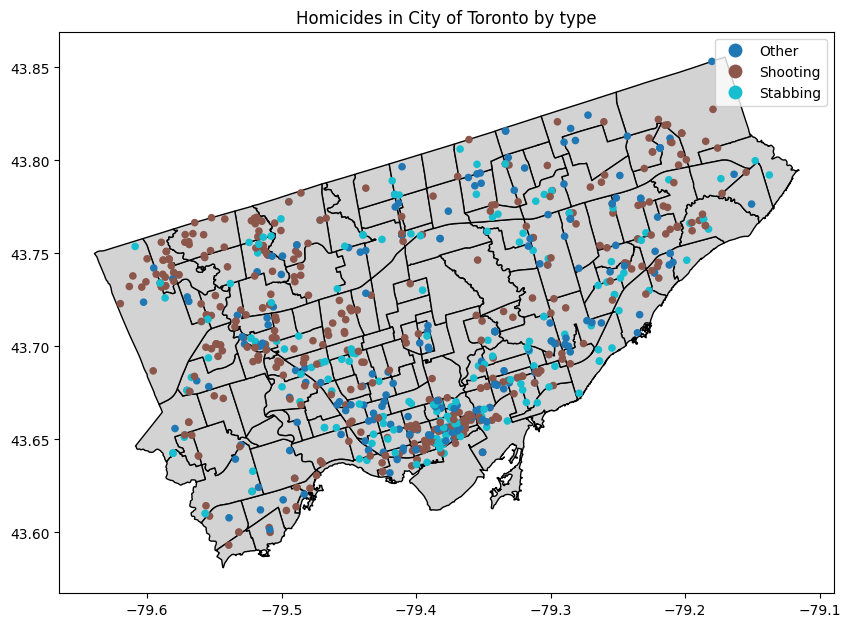

In [20]:
ax = gdf_neigh.plot(figsize=(10, 10), color='lightgrey', edgecolor='black')
homicides_gdf.plot(ax=ax, markersize=20, zorder=2, column="HOMICIDE_TYPE", legend=True)
plt.title('Homicides in City of Toronto by type')

This is bit intresting! On high level view it looks like it completely random distribution but if we closely observe we have some kind of density over certain area. Lets use scipy.stats.gaussian_kde to identify areas of high concentration, or 'hot spots', of each homicide types by estimating the density of point patterns.<br>
References used:
1. gaussian_kde: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.gaussian_kde.html
2. KDE Silverman's rule of thumb: https://en.wikipedia.org/wiki/Kernel_density_estimation#A_rule-of-thumb_bandwidth_estimator
3. Contourf plotting: https://matplotlib.org/stable/gallery/images_contours_and_fields/irregulardatagrid.html#sphx-glr-gallery-images-contours-and-fields-irregulardatagrid-py

In [21]:
shooting_homicides_gdf = homicides_gdf[homicides_gdf['HOMICIDE_TYPE'] == 'Shooting']
stabbing_homicides_gdf = homicides_gdf[homicides_gdf['HOMICIDE_TYPE'] == 'Stabbing']
other_homicides_gdf = homicides_gdf[homicides_gdf['HOMICIDE_TYPE'] == 'Other']

In [22]:
import numpy as np
from scipy.stats import gaussian_kde

# Function to perform KDE and plot results with neighborhoods in background
def plot_kde(homicide_gdf, gdf_neigh, ax, title, color):
    # Extract the x and y coordinates of the points
    x = homicide_gdf.geometry.x
    y = homicide_gdf.geometry.y

    # Creating a grid of points where we want to evaluate the KDE
    xmin, ymin, xmax, ymax = gdf_neigh.total_bounds
    xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j] # 100j specifies 100 x 100 grid

    # Perform the kernel density estimate
    positions = np.vstack([xx.ravel(), yy.ravel()])
    values = np.vstack([x, y])
    kernel = gaussian_kde(values, bw_method='silverman')
    f = np.reshape(kernel(positions).T, xx.shape)

    # Plot the neighborhoods as a background
    gdf_neigh.plot(ax=ax, color='lightgrey', edgecolor='black')

    # Plot the results: contour map
    ax.contourf(xx, yy, f, levels=15, cmap=color, alpha=0.7) # setting alpha to make neighborhoods visible
    ax.set_title(title)
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)


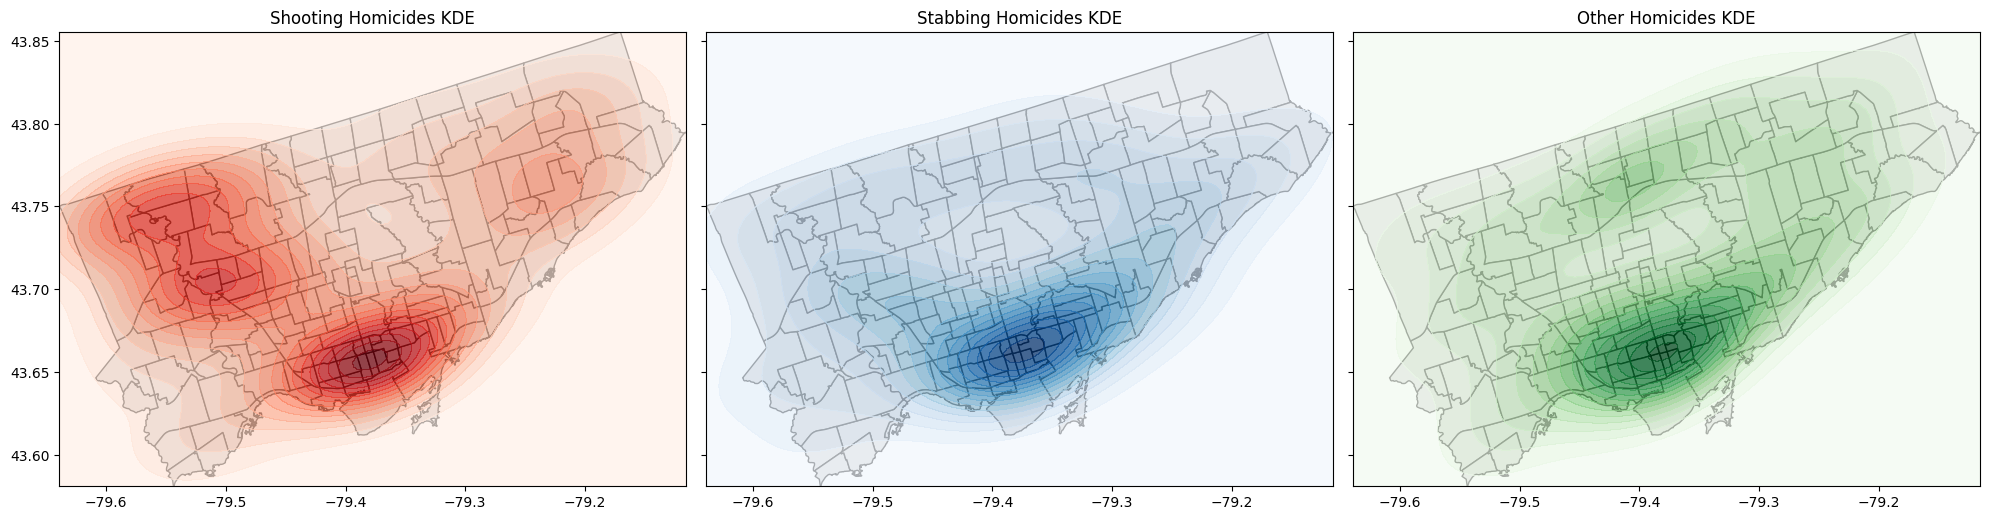

In [23]:
# Prepare the figure and axes
fig, axs = plt.subplots(1, 3, figsize=(20, 6), sharex=True, sharey=True)

# Plot KDE for each homicide type with neighborhoods
plot_kde(shooting_homicides_gdf, gdf_neigh, axs[0], 'Shooting Homicides KDE', 'Reds')
plot_kde(stabbing_homicides_gdf, gdf_neigh, axs[1], 'Stabbing Homicides KDE', 'Blues')
plot_kde(other_homicides_gdf, gdf_neigh, axs[2], 'Other Homicides KDE', 'Greens')

# Display the plot
plt.tight_layout()
plt.show()

The KDE plots for the three types of homicides—shooting, stabbing, and other—reveal the spatial patterns within the City of Toronto. stabbing is highly concentrated in Southern area. Shooting we see 2 major spots. This is a good representation to visulize the spatial patterns.

# PART B
## 3. What is the probability that this spatial pattern could have arisen by chance (Moran’s I)? (Include graphs and or text to support your answer.)

Moran's I: This statistic measures the degree of similarity between locations and their neighbors. A positive Moran's I indicates a tendency for similar values to cluster together (positive autocorrelation), while a negative value indicates a tendency for dissimilar values to be nearby (negative autocorrelation). A value close to zero suggests a random spatial pattern.

To do this we'll have to follow following steps.
1. Aggregate homicides by neighborhood code
2. Merge with neighborhood geometries and clean the data
3. Create a spatial weights matrix
4. Compute Moran's I 

In [24]:
# Step 1: Aggregate homicides by neighborhood code
homicide_counts = homicides_gdf.groupby('NEIGHBOURHOOD_140').size().reset_index(name='homicide_count')
homicide_counts

,NEIGHBOURHOOD_140,homicide_count
0,Agincourt North (129),2
1,Agincourt South-Malvern West (128),4
2,Alderwood (20),4
3,Annex (95),3
4,Banbury-Don Mills (42),1
...,...,...
122,Woodbine-Lumsden (60),4
123,Wychwood (94),3
124,Yonge-Eglinton (100),3
125,York University Heights (27),17


Now Merging with neighborhood geometries we have to see which columns to merge. By looking at gdf_neigh and homicides_gdf we see that AREA_DESC and NEIGHBOURHOOD_140 are good columns to join

In [25]:
# Step 2: Merge with neighborhood geometries
neighborhood_homicides = gdf_neigh.merge(homicide_counts, left_on='AREA_DESC', right_on='NEIGHBOURHOOD_140', how='left')
neighborhood_homicides

,_id,AREA_ID,AREA_ATTR_ID,PARENT_AREA_ID,AREA_SHORT_CODE,AREA_LONG_CODE,AREA_NAME,AREA_DESC,CLASSIFICATION,CLASSIFICATION_CODE,OBJECTID,geometry,NEIGHBOURHOOD_140,homicide_count
0,1,2502366,26022881,0,174,174,South Eglinton-Davisville,South Eglinton-Davisville (174),Not an NIA or Emerging Neighbourhood,NA,17824737.0,"MULTIPOLYGON (((-79.38635 43.69783, -79.38623 ...",NaN,NaN
1,2,2502365,26022880,0,173,173,North Toronto,North Toronto (173),Not an NIA or Emerging Neighbourhood,NA,17824753.0,"MULTIPOLYGON (((-79.39744 43.70693, -79.39837 ...",NaN,NaN
2,3,2502364,26022879,0,172,172,Dovercourt Village,Dovercourt Village (172),Not an NIA or Emerging Neighbourhood,NA,17824769.0,"MULTIPOLYGON (((-79.43411 43.66015, -79.43537 ...",NaN,NaN
3,4,2502363,26022878,0,171,171,Junction-Wallace Emerson,Junction-Wallace Emerson (171),Not an NIA or Emerging Neighbourhood,NA,17824785.0,"MULTIPOLYGON (((-79.43870 43.66766, -79.43841 ...",NaN,NaN
4,5,2502362,26022877,0,170,170,Yonge-Bay Corridor,Yonge-Bay Corridor (170),Not an NIA or Emerging Neighbourhood,NA,17824801.0,"MULTIPOLYGON (((-79.38404 43.64497, -79.38502 ...",NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153,154,2502213,26022728,0,001,001,West Humber-Clairville,West Humber-Clairville (1),Not an NIA or Emerging Neighbourhood,NA,17827185.0,"MULTIPOLYGON (((-79.59037 43.73401, -79.58942 ...",West Humber-Clairville (1),14.0
154,155,2502212,26022727,0,024,024,Black Creek,Black Creek (24),Neighbourhood Improvement Area,NIA,17827201.0,"MULTIPOLYGON (((-79.51915 43.77399, -79.51901 ...",Black Creek (24),10.0
155,156,2502211,26022726,0,023,023,Pelmo Park-Humberlea,Pelmo Park-Humberlea (23),Not an NIA or Emerging Neighbourhood,NA,17827217.0,"MULTIPOLYGON (((-79.53225 43.73505, -79.52938 ...",Pelmo Park-Humberlea (23),8.0
156,157,2502210,26022725,0,022,022,Humbermede,Humbermede (22),Neighbourhood Improvement Area,NIA,17827233.0,"MULTIPOLYGON (((-79.52813 43.74425, -79.52721 ...",Humbermede (22),2.0


In [26]:
# Replace NaN values with 0 for neighborhoods with no homicides
neighborhood_homicides['homicide_count'] = neighborhood_homicides['homicide_count'].fillna(0)

In [28]:
# Step 3: Create a spatial weights matrix
from libpysal.weights import Queen
w = Queen.from_dataframe(neighborhood_homicides, use_index=False)
w.transform = 'r'  # row-standardize the weights

Moran's I: 0.23307707668716912
Expected Moran's I under CSR: -0.006369426751592357
p-value: 0.001


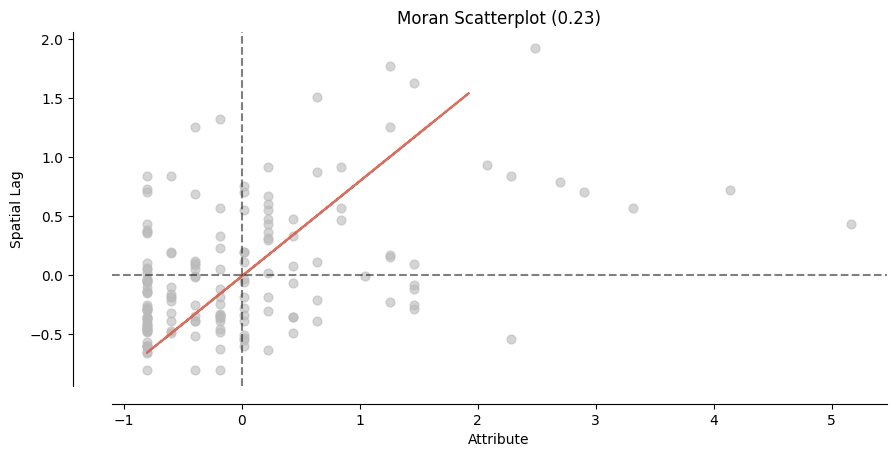

In [30]:
# Step 4: Compute Moran's I
from esda.moran import Moran
mi = Moran(neighborhood_homicides['homicide_count'], w)

# Output the results
print(f"Moran's I: {mi.I}")
print(f"Expected Moran's I under CSR: {mi.EI}")
print(f"p-value: {mi.p_sim}")

# Visualization
# Moran's Scatterplot
from splot.esda import moran_scatterplot
fig, ax = plt.subplots(figsize=(10, 10), nrows=1, ncols=1)
moran_scatterplot(mi, ax=ax)
plt.show()


### Conclusion: Not Occured by chance

* Moran's I value (aprox. 0.23): This positive value suggests that there is a positive spatial autocorrelation in homicide data. In other words, locations with high numbers of homicides are more likely to be near other locations with high numbers, and locations with low numbers are near others with low numbers.

* Expected Moran's I under CSR (aprox. -0.0064): This is the expected value of Moran's I if the spatial distribution of homicides was completely random (under the null hypothesis of Complete Spatial Randomness). The actual Moran's I being much higher than the expected value indicates non-randomness

* p-value (0.001): This is the probability of observing a Moran's I as extreme as, or more extreme than, the one calculated from the data if the null hypothesis of complete spatial randomness were true. A p-value of 0.001 is very low, which allows us to reject the null hypothesis with high confidence. In other words, the observed spatial pattern is highly unlikely to have occurred by chance.

### 4. What are some other factors that might influence the location of these types of crimes? Use plots or graphs as necessary to support your response. (200 - 400 words) 
#### You might explore data from the City of Toronto, https://www.toronto.ca/city-government/data-researchmaps/open-data/, or datasets from other providers, e.g.: https://open.canada.ca/en

### Answer:

First Lets see if there are crime control units like police stations are available near to these homicide incidents. Fo this we will use toronto Police Facility Locations geojson. (https://open.toronto.ca/dataset/police-facility-locations/)

In [89]:
# Please keep given geojson file in Data folder.
gdf_police_station = gpd.read_file("Data/PoliceFacilityLocations.geojson")
gdf_police_station.head()

,_id,OBJECTID_1,FACILITY,ORGANIZATION,ADDRESS,POSTAL_CODE,geometry
0,1,1,11 Division,Toronto Police Services,2054 Davenport Road,M6N 1C8,MULTIPOINT (-79.46083 43.67108)
1,2,2,12 Division,Toronto Police Services,200 Trethewey Drive,M6M 5E6,MULTIPOINT (-79.48688 43.69458)
2,3,3,13 Division,Toronto Police Services,1435 Eglinton Avenue West,M6C 3Z4,MULTIPOINT (-79.43668 43.69833)
3,4,4,14 Division,Toronto Police Services,350 Dovercourt Road,M6J 3E3,MULTIPOINT (-79.42598 43.65131)
4,5,5,22 Division,Toronto Police Services,3699 Bloor Street West,M9A 1A2,MULTIPOINT (-79.52918 43.64311)


Now loer plot this station and homicide incident together and lets see if we see any corelation. (May be lack of crime control unit?)

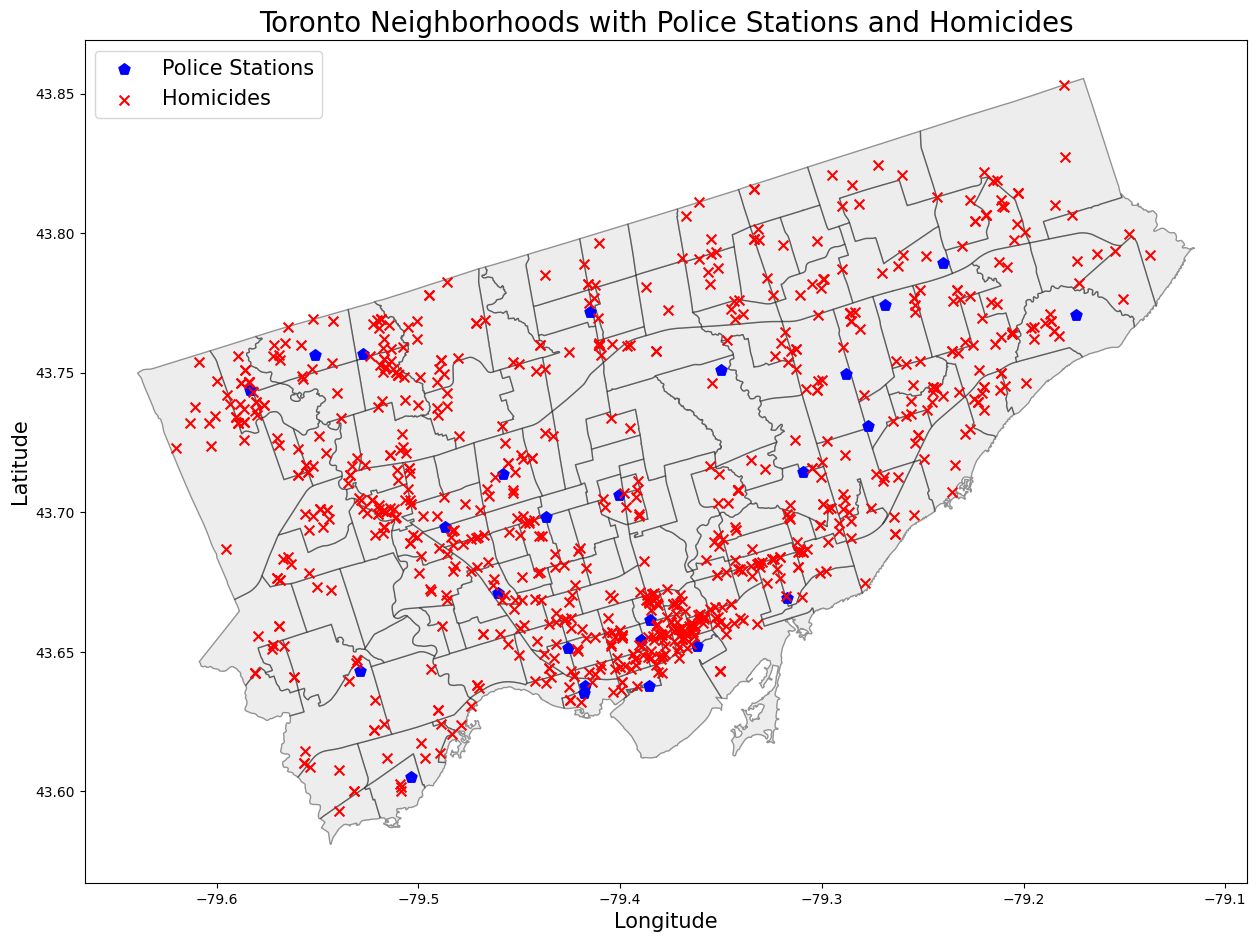

In [90]:
# Plot the neighborhood map as the base layer
ax = gdf_neigh.plot(figsize=(15, 15), color='lightgrey', edgecolor='black', alpha=0.4)

# Plot police stations on the neighborhood map
gdf_police_station.plot(ax=ax, marker='p', color='blue', markersize=70, label='Police Stations')

# Plot homicide data on the same map
homicides_gdf.plot(ax=ax, marker='x', color='red', markersize=50, label='Homicides')

plt.legend(prop={'size': 15})
plt.title('Toronto Neighborhoods with Police Stations and Homicides', fontsize=20)
plt.xlabel('Longitude', fontsize=15)
plt.ylabel('Latitude', fontsize=15)
plt.show()


Police stations are distributed throughout Toronto, there doesn't appear to be an immediate visual correlation between the density of homicides and proximity to police stations. Because we cna see that there are stations near by.

Now lets see some other reports that might directly have relation with homicides. I found this intresting data set named "Shootings & Firearm Discharges" This data set says - "As there is no criminal offence code for shootings, a shooting occurrence number may also be present in other data sets including, but not limited to, assault and robbery." (https://open.toronto.ca/dataset/shootings-firearm-discharges/)

So lets see if the shooting occurences can draw any indirect implication towards homicide.

In [91]:
# Load Shootings & Firearm Discharges data
gdf_shootings = gpd.read_file("Data/shootings-firearm-discharges.geojson")
gdf_shootings.head()

,_id,EVENT_UNIQUE_ID,OCC_DATE,OCC_YEAR,OCC_MONTH,OCC_DOW,OCC_DOY,OCC_DAY,OCC_HOUR,OCC_TIME_RANGE,DIVISION,DEATH,INJURIES,HOOD_158,NEIGHBOURHOOD_158,HOOD_140,NEIGHBOURHOOD_140,geometry
0,1,GO-2004133803,,2004.0,January,Thursday,1.0,1.0,0.0,Night,D31,0.0,1.0,23,Pelmo Park-Humberlea,23,Pelmo Park-Humberlea (23),MULTIPOINT (-79.53822 43.73374)
1,2,GO-2004120070,1073-10-06,2004.0,January,Saturday,3.0,3.0,1.0,Night,D54,0.0,0.0,NSA,NSA,NSA,NSA,MULTIPOINT (0.00000 0.00000)
2,3,GO-2004135509,,2004.0,January,Sunday,4.0,4.0,4.0,Night,D14,0.0,2.0,78,Kensington-Chinatown,78,Kensington-Chinatown (78),MULTIPOINT (-79.39916 43.65612)
3,4,GO-2004126451,,2004.0,January,Monday,5.0,5.0,13.0,Afternoon,D41,0.0,1.0,124,Kennedy Park,124,Kennedy Park (124),MULTIPOINT (-79.25604 43.73290)
4,5,GO-2004136310,,2004.0,January,Tuesday,6.0,6.0,19.0,Evening,D42,0.0,0.0,146,Malvern East,132,Malvern (132),MULTIPOINT (-79.20652 43.80835)


Some data is not having gemetry lets clean it out by droping them. ( Reason: In 2014, the Toronto Police Service changed records management systems. For occurrences prior to this date, coordinates are limited, therefore for some events with NULL coordinates the neighbourhood will be identified as ‘NSA’ to indicate ‘Not Specified Area.’)

In [92]:
gdf_shootings.drop(gdf_shootings[gdf_shootings.NEIGHBOURHOOD_140 == "NSA"].index, inplace=True)

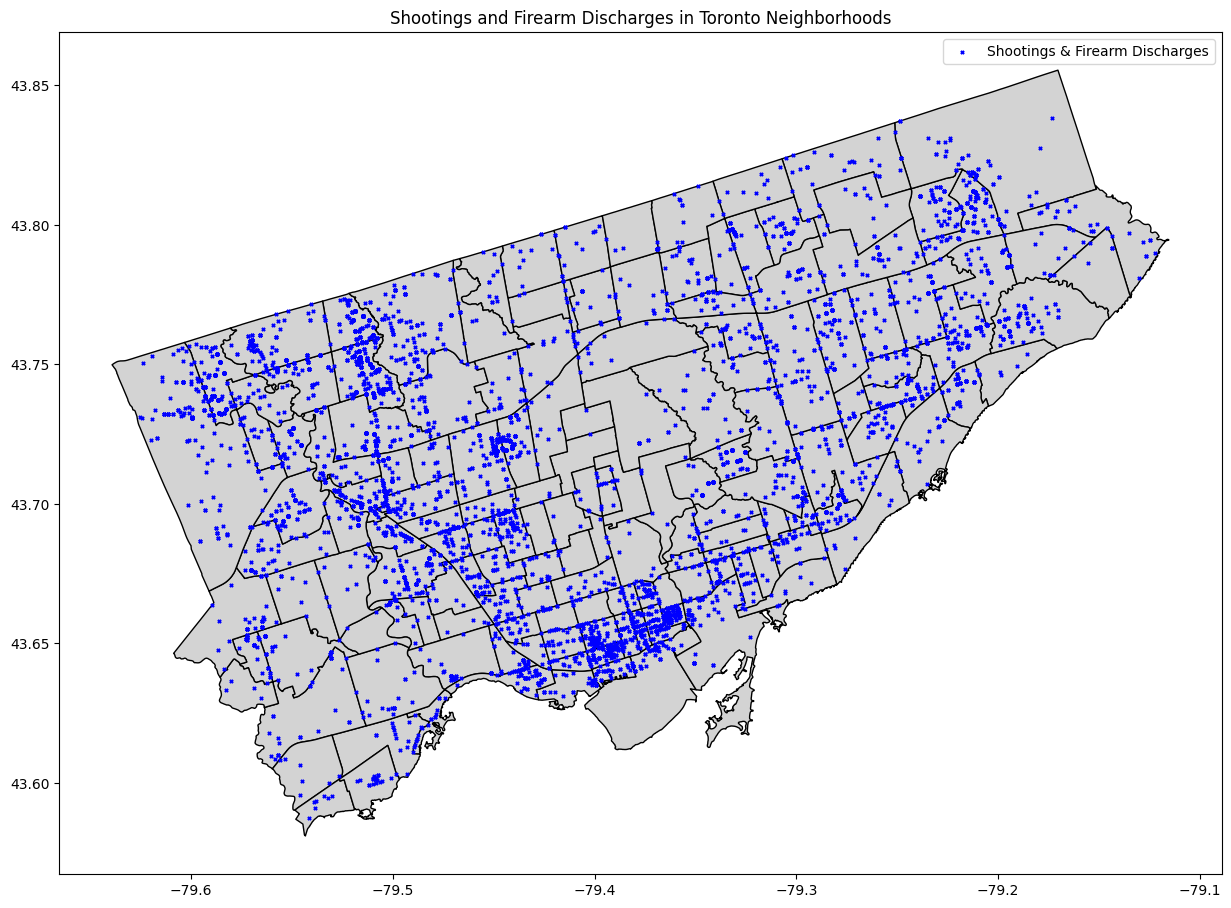

In [93]:
# Plot the neighborhood map as the base
ax = gdf_neigh.plot(figsize=(15, 15), color='lightgrey', edgecolor='black')

# Plot shootings and firearm discharges on top of the neighborhood map
gdf_shootings.plot(ax=ax, marker='x', color='blue', markersize=5, label='Shootings & Firearm Discharges')
plt.legend()
plt.title('Shootings and Firearm Discharges in Toronto Neighborhoods')
plt.show()

This is would be a good data comparison if we could see if there are any co relation between this shooting data and homicides whose HOMICIDE_TYPE is Shooting.

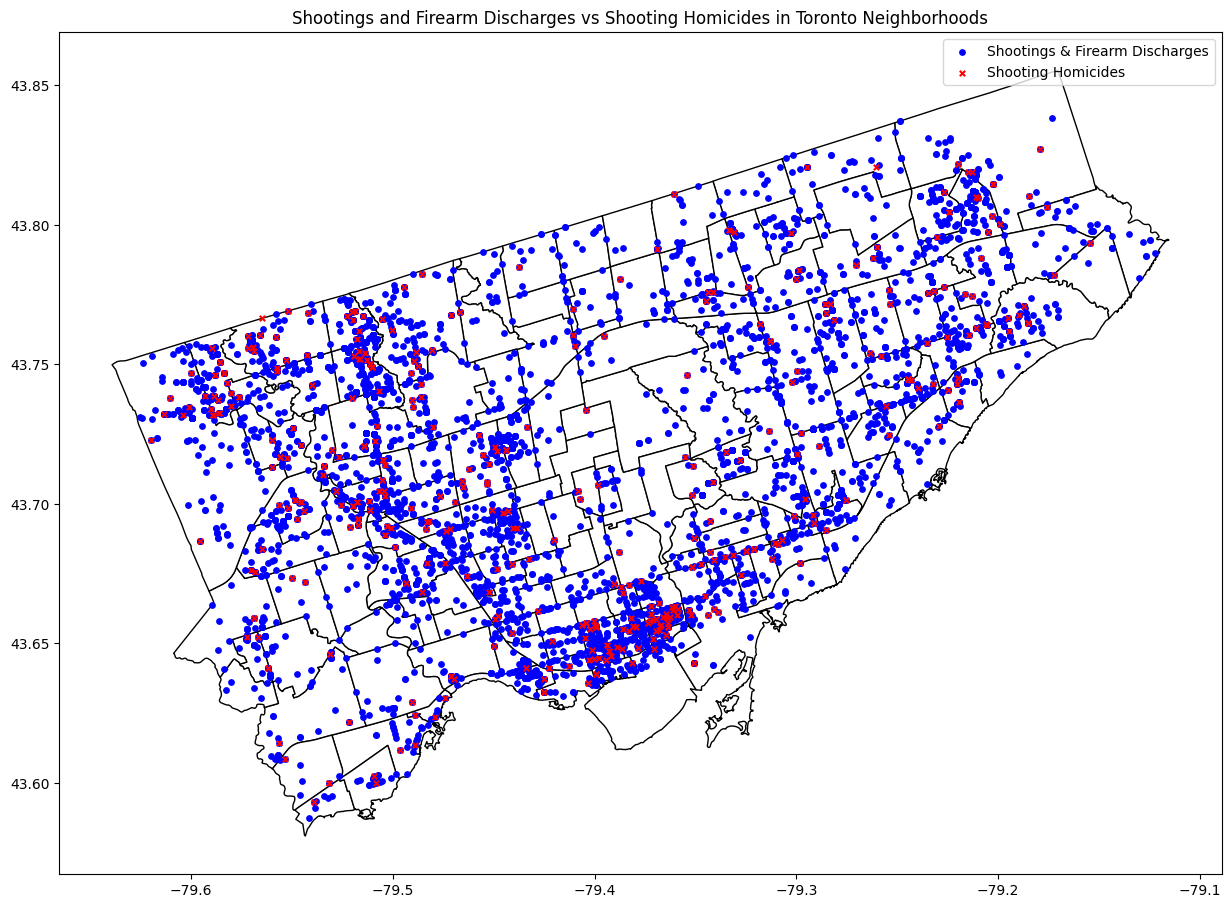

In [94]:

# Plot the neighborhood map as the base
ax = gdf_neigh.plot(figsize=(15, 15), color='w', edgecolor='black')

# Plot shootings and firearm discharges on the neighborhood map
gdf_shootings.plot(ax=ax, marker='o', color='b', markersize=15, label='Shootings & Firearm Discharges')

# Plot shooting-related homicides on the same map
shooting_homicides_gdf.plot(ax=ax, marker='x', color='red', markersize=15, label='Shooting Homicides')

# Add legend and title
plt.legend()
plt.title('Shootings and Firearm Discharges vs Shooting Homicides in Toronto Neighborhoods')

# Show the plot
plt.show()


The map suggests spatial correlation. The data visually suggest that instances of firearm discharges and subsequent homicides tend to occur in proximity to each other.This pattern implies that areas experiencing a higher frequency of shootings are also more likely to witness homicides resulting from these firearm incidents.